<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/testing/T_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime
import math

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
#from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (413 , 550), antialias = True)
    img = img / 255.0
    return img

In [27]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.2,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
      img_name = img.split('/')[-1]
      orig_path = orig_img_path + '/' + img_name
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      else:
        val_img.append([img, orig_path])
    return train_img, val_img

def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/generated_dataset/trans'
  haze_pth='/content/drive/MyDrive/generated_dataset/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [28]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [29]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

In [57]:
layers = tf.keras.layers

class T_net(tf.keras.Model):
  def __init__(self):
    super(T_net,self).__init__()
    self.conv1=Conv2D(input_shape = (413, 550, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv2=Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    self.conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))
    
  def call(self,inputs):   
    #inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)
    #atm=self.get_dark_channel(inputs,15)
    #atm=self.atmlight(inputs,atm)


    


    conv1 = self.conv1(inputs)
    
    conv2 = self.conv2(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = self.conv3(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = self.conv4(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = self.conv5(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(K)#(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return output

  def model(self):
        x = Input(shape = (412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))

  def updt(self):
        self.conv1.trainable = False
        self.conv2.trainable = False
        self.conv3.trainable = False


  def __str__(self):
      return "\nd1:{0}\nd2:{1}".format(self.conv4.trainable, self.conv5.trainable)
    

    
  def build_graph(self):
        x = Input(shape=(412, 548, 3))
        return Model(inputs=[x], outputs=self.call(x))


In [77]:
tnet = T_net()
tnet = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)

'''# define layer block
layer = T_net()
#layer = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
layer.model().load_weights('/content/drive/MyDrive/nets/dehazenet')

seq_model = tf.keras.models.Sequential
model = seq_model()
model.add(layers.Input(shape=(413, 550, 3)))
model.add(layer)'''

"# define layer block\nlayer = T_net()\n#layer = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)\nlayer.model().load_weights('/content/drive/MyDrive/nets/dehazenet')\n\nseq_model = tf.keras.models.Sequential\nmodel = seq_model()\nmodel.add(layers.Input(shape=(413, 550, 3)))\nmodel.add(layer)"

In [69]:
# Use updt function to make layers non-trainable
for i, layer in enumerate(model.layers):
    layer.updt()

In [78]:
tnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 413, 550, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 413, 550, 3)  12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 413, 550, 3)  84          conv2d_5[0][0]                   
__________________________________________________________________________________________________
tf.concat_3 (TFOpLambda)        (None, 413, 550, 6)  0           conv2d_5[0][0]                   
                                                                 conv2d_6[0][0]             

In [32]:
# Hyperparameters
epochs = 5
batch_size = 16
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/generated_dataset/trans', hazy_img_path = '/content/drive/MyDrive/generated_dataset/hazy')
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")


8454


In [33]:
def train_model_enhance(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #loss = mean_squared_error(train_batch_orig, train_logits)
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                loss=mean_squared_error(train_batch_orig, train_logits)#.numpy

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('/content/drive/MyDrive/nets/t_net/trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [=========]  -  Training Loss: 0.0344

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


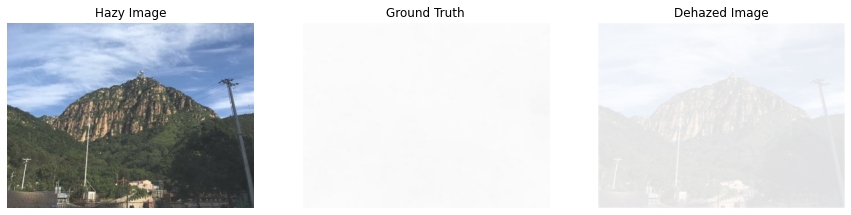

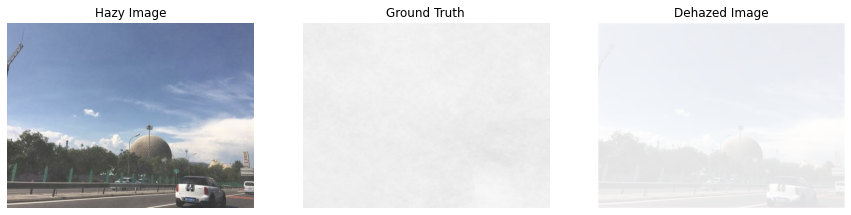

  -  Validation Loss: 0.0057  -   Time taken: 8253.64s
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/t_net/trained_model/assets

Start of epoch 1 [=========]  -  Training Loss: 0.0056

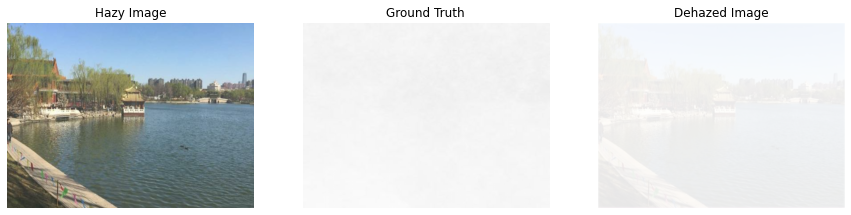

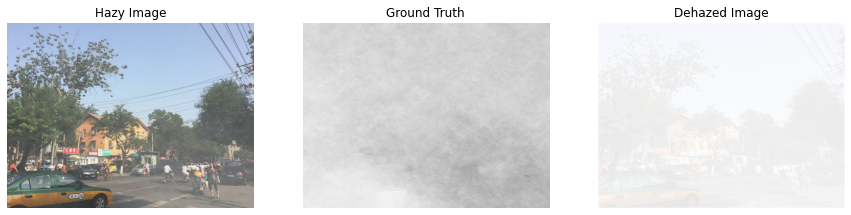

  -  Validation Loss: 0.0056  -   Time taken: 226.39s
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/t_net/trained_model/assets

Start of epoch 2 [=========]  -  Training Loss: 0.0055

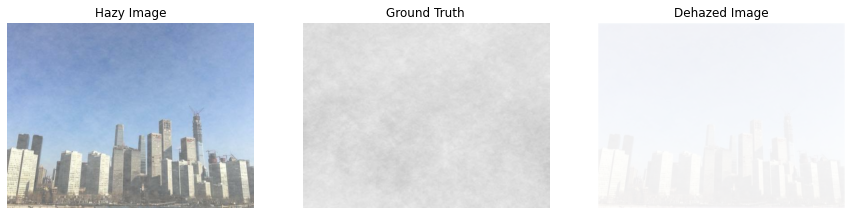

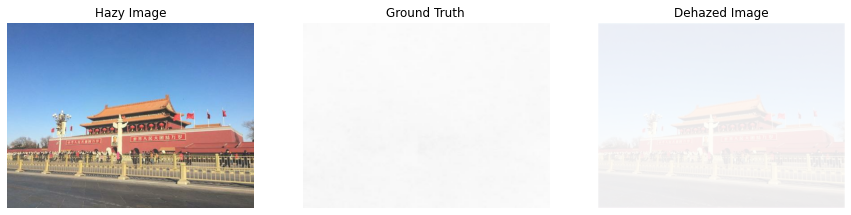

  -  Validation Loss: 0.0055  -   Time taken: 231.03s
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/t_net/trained_model/assets

Start of epoch 3 [=========]  -  Training Loss: 0.0055

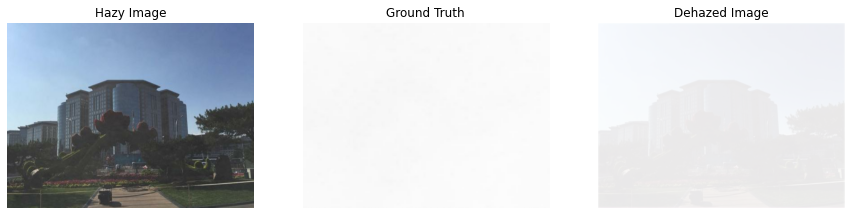

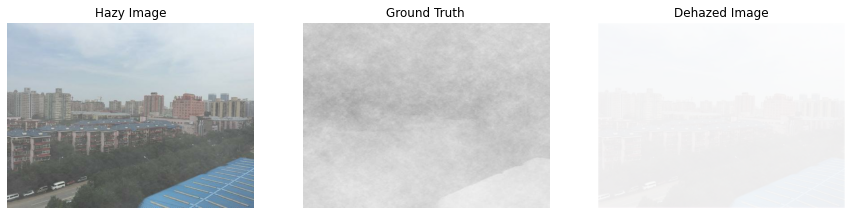

  -  Validation Loss: 0.0055  -   Time taken: 228.33s
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/t_net/trained_model/assets

Start of epoch 4 [=========]  -  Training Loss: 0.0054

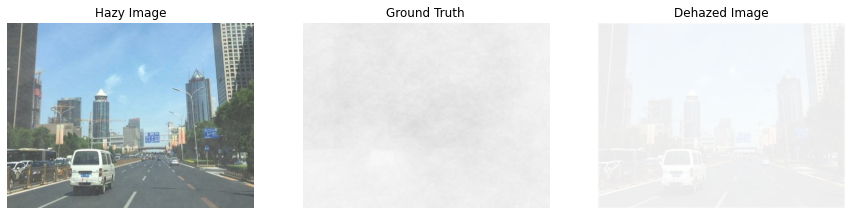

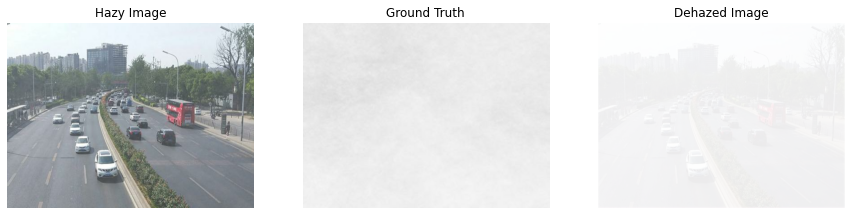

  -  Validation Loss: 0.0054  -   Time taken: 227.42s
INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/t_net/trained_model/assets
CPU times: user 16min 12s, sys: 41 s, total: 16min 53s
Wall time: 2h 32min 52s


In [79]:
%%time
#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/multihaze',compile=False)
train_model_enhance(epochs, train, val,tnet,train_loss_tracker, val_loss_tracker, optimizer)

In [80]:
 tnet.save_weights('/content/drive/MyDrive/nets/t_net/5e')